# Toy Example

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.costs import RevGaussCost
from loss_cal.utils.utils import load_data, atleast_2d_col
from loss_cal.predictor import train, build_nn
from loss_cal.actions import Action
from sbi.utils.torchutils import atleast_2d
from sbi.utils.sbiutils import gradient_ascent
from functools import partial


plot_config_file = "loss_cal/utils/.matplotlibrc"
color_npe = '#377eb8'
color_nn = '#ff7f00'
color_post = '#4daf4a'

## Set Up

In [33]:
toy = ToyExample(action_type="continuous")
toy.task_name

'toy_example'

Prior and Simulator

In [34]:
prior = toy.get_prior()
simulator = toy.get_simulator()

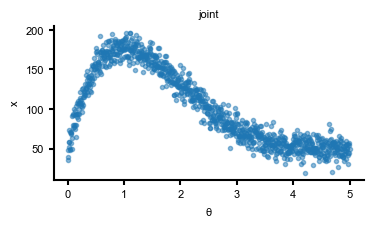

In [35]:
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1,1, figsize=(4,2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5); 
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel('x'); ax.set_title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Posterior

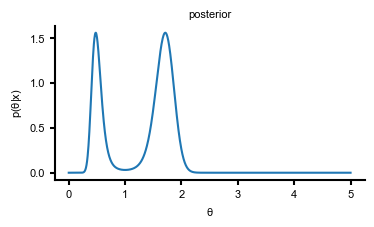

In [36]:
resolution = 1000
x = 150
posterior_evals = toy.gt_posterior(torch.Tensor([x]))
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    thetas = torch.linspace(toy.param_low.item(), toy.param_high.item(), resolution)
    ax.plot(thetas, posterior_evals)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Continuous Actions

### Decision Task

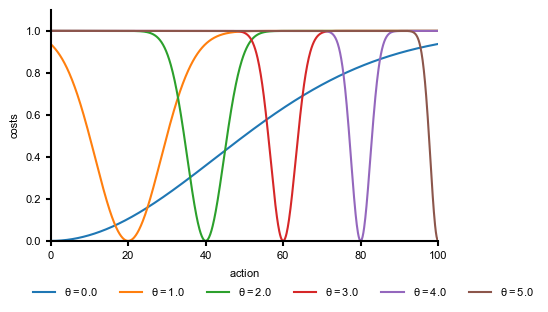

In [37]:
# loss = SquaredLoss(factor=1)
factor = 3
exponential = 1
cost_fn = RevGaussCost(parameter_range=toy.param_high - toy.param_low, action_range=toy.action_high-toy.action_low, factor=factor, exponential=exponential)

with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    actions = torch.arange(toy.action_low, toy.action_high, (toy.action_high - toy.action_low) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for theta in torch.arange(toy.param_low.item(), toy.param_high.item()+0.01, 1):
        ax.plot(actions, cost_fn(theta, actions), label=rf"$\theta={theta}$")

    ax.set_xlabel(r"$action$")
    ax.set_ylabel("costs")
    ax.set_xlim(toy.action_low, toy.action_high)
    ax.set_ylim(0, 1.1)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

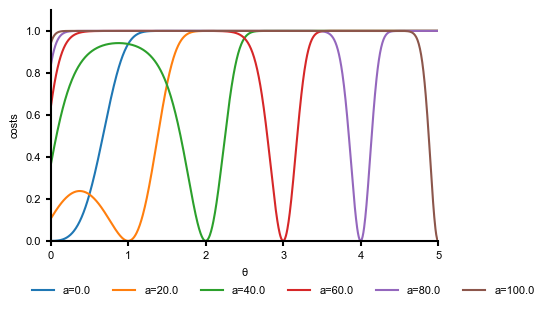

In [38]:
with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    thetas = torch.arange(toy.param_low.item(), toy.param_high.item(), (toy.param_high.item() - toy.param_low.item()) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for a in torch.arange(toy.action_low, toy.action_high+0.01, 20):
        ax.plot(thetas, cost_fn(thetas, a), label=f"a={a}")

    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("costs")
    ax.set_xlim(toy.param_low.item(), toy.param_high.item())
    ax.set_ylim(0, 1.1)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

### Actions

In [39]:
actions = toy.actions

### Load data

In [40]:
n_train = 1_000
n_test = 5_000

(
    theta_train,
    x_train,
    theta_val,
    x_val,
    theta_test,
    x_test,
) = load_data("toy_example")


x_train = x_train[:n_train]
x_val = x_val[:n_test]
x_test = x_test[:n_test]
theta_train = toy.param_aggregation(theta_train[:n_train])
theta_val = toy.param_aggregation(theta_val[:n_test])
theta_test = toy.param_aggregation(theta_test[:n_test])


print(f"N_train = {theta_train.shape[0]}, N_val = {theta_val.shape[0]}, N_test = {theta_test.shape[0]}")

Load data from './data/toy_example', device = cpu.
N_train = 1000, N_val = 5000, N_test = 5000


### Train a neural network to predict expected costs

In [41]:
nn = build_nn(
    "fc",
    x_train=x_train,
    action_train=toy.actions.sample(theta_train.shape[0]),
    hidden_dims=[100, 100, 100],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.Sigmoid(),
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn= cost_fn, 
    x_val=x_val,
    theta_val=theta_val,
    actions=toy.actions, 
    learning_rate=1e-3,
    model_dir="./results/toy_example/continuous/notebook",
    #max_num_epochs=800,
    stop_after_epochs=50,
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=100, out_features=100, bias=True)
  )
  (final_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Sigmoid()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
Converged after 208 epochs. train_loss = 0.05445975	 last_improvement = 22


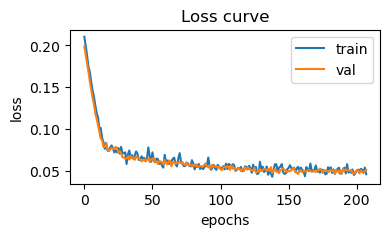

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label="val")
ax.set_title("Loss curve")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()

### Evaluate model

#### Check predictions on the training data

In [43]:
actions_evaluate = toy.actions.sample(theta_train.shape[0])

In [44]:
predictions_train = nn(x_train, actions_evaluate)
true_expected_costs_train = torch.Tensor(
    [
        toy.expected_posterior_costs(
            x_o, a_o, cost_fn=cost_fn
        )
        for x_o, a_o in zip(x_train, actions_evaluate)
    ]
)

In [45]:
# MSE
print(f"MSE on training data: {((predictions_train.squeeze() - true_expected_costs_train)**2).mean() :.6f}")

MSE on training data: 0.002617


#### Check incurred losses

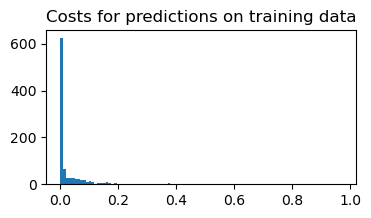

In [46]:
losses_train = torch.mean((cost_fn(theta_train, actions_evaluate) - predictions_train) ** 2, dim=1)
# torch.median(losses_train), torch.mean(losses_train)
plt.figure(figsize=(4, 2))
plt.hist(losses_train.detach().numpy(), bins=100)
plt.title("Costs for predictions on training data")
plt.show()

#### Check true and predicted expected costs

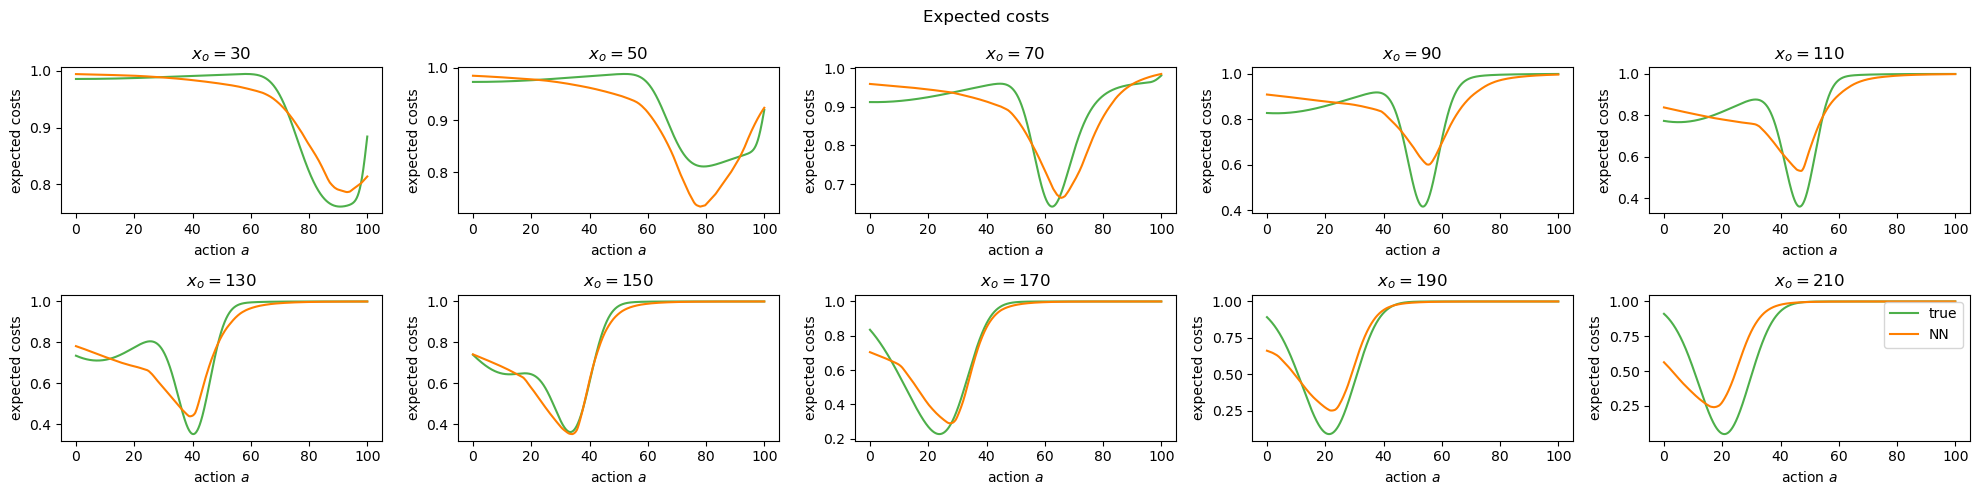

In [47]:
obs = torch.arange(30, 230, 20)
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

plt.figure(figsize=(20, 5))
for i, x in enumerate(obs):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = toy.expected_posterior_costs(
                x=x,
                a=a_grid,
                # lower=toy.param_low.item(),
                # upper=toy.param_high.item(),
                # resolution=resolution,
                cost_fn=cost_fn
            )

    predicted_costs = torch.tensor([nn(x,a) for a in a_grid])

    plt.plot(a_grid, expected_posterior_costs.squeeze(), c=color_post, label="true")
    plt.plot(a_grid, predicted_costs, c=color_nn, label="NN")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_o=${x}")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
# plt.savefig("./results/continuous/toy_example/fig_expected_costs.pdf")
plt.show()

Resulting divergence in the chosen action

In [48]:
obs_grid = torch.arange(0, 220, 5)
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

expected_posterior_losses = [
    torch.tensor(
            toy.expected_posterior_costs(
                x=x_o,
                a=a_grid,
                cost_fn=cost_fn
            )
    )
    for x_o in obs_grid
]
expected_posterior_losses = torch.vstack(expected_posterior_losses)
predicted_losses = [torch.tensor([nn(x_o.reshape(-1, 1), a.reshape(-1, 1)) for a in a_grid]) for x_o in obs_grid]
predicted_losses = torch.stack(predicted_losses, dim=0)


a_gt = a_grid[expected_posterior_losses.argmin(dim=1)]
a_predicted = a_grid[predicted_losses.argmin(dim=1)]

(a_gt - a_predicted).abs().mean()

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_47564/169522329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


tensor(2.5261)

Resulting divergence in the incurred costs

In [49]:
torch.tensor(
    [
        (toy.expected_posterior_costs(x_o, a_true, cost_fn=cost_fn) - toy.expected_posterior_costs(x_o, a_pred, cost_fn=cost_fn)).abs()
        for x_o, a_true, a_pred in zip(obs_grid, a_gt, a_predicted)
    ]
).mean()

tensor(0.0354)

### Find the optimal action

Use gradient descent on the reverse expected costs (rescaled by the maximum) to find the optimal action

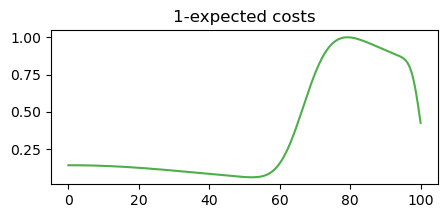

In [50]:
obs = torch.tensor([50.0])
a_grid = torch.arange(toy.action_low, toy.action_high, 0.05)

plt.figure(figsize=(5, 2))

expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_costs(
            x=obs,
            a=a,
            cost_fn=cost_fn
        )
        for a in a_grid
    ]
)
predicted_losses = torch.tensor([nn(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = 1 - expected_posterior_losses
plt.title("1-expected costs")
plt.plot(a_grid, reverse_costs / reverse_costs.max(), c=color_post, label="true")
plt.show()

In [51]:
from loss_cal.utils.analysis import expected_costs_wrapper

In [52]:
def reverse_costs(x: torch.Tensor, a: torch.Tensor, dist: str,cost_fn, nn=None) -> torch.Tensor:
    return 1 - expected_costs_wrapper(x, a, toy, dist, param=0, nn=nn, cost_fn=cost_fn)


reverse_costs_given_x_nn = partial(reverse_costs, obs, dist="nn", nn=nn, cost_fn=cost_fn)
reverse_costs_given_x_post = partial(reverse_costs, obs, dist="posterior", nn=None, cost_fn=cost_fn)

In [53]:
initial_actions = actions.sample(1000)
gd_best_action_nn, gd_costs_nn = gradient_ascent(
    potential_fn=reverse_costs_given_x_nn, inits=initial_actions, theta_transform=None
)
gd_best_action_nn, gd_costs_nn

(tensor([77.9887]), tensor([0.2652]))

In [54]:
gd_best_action_post, gd_costs_post = gradient_ascent(
    potential_fn=reverse_costs_given_x_post, inits=initial_actions, theta_transform=None
)
gd_best_action_post, gd_costs_post

(tensor([79.1925]), tensor([0.1886]))

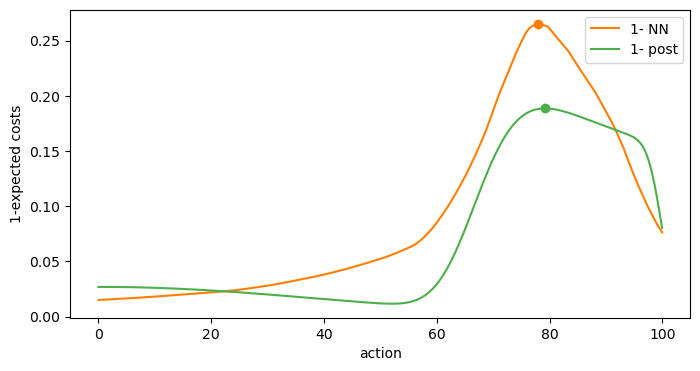

In [55]:
plt.figure(figsize=(8, 4))

expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_costs(
            x=obs,
            a=a,
            cost_fn=cost_fn
        )
        for a in a_grid
    ]
)
predicted_losses = torch.tensor([nn(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = 1 - expected_posterior_losses
# plt.plot(a_grid, reverse_costs/reverse_costs.max(), label="true")
plt.scatter(gd_best_action_post, gd_costs_post, c=color_post)
plt.scatter(gd_best_action_nn, gd_costs_nn, c=color_nn)

plt.plot(a_grid, 1 - predicted_losses, label="1- NN", c=color_nn)
plt.plot(a_grid, reverse_costs, label="1- post", c=color_post)
plt.xlabel("action")
plt.ylabel("1-expected costs")
plt.legend()
# plt.plot(a_grid, predicted_losses, label="NN")
plt.show()

Test Code

In [56]:
from loss_cal.utils.analysis import find_optimal_action

In [57]:
post_action, _, post_costs = find_optimal_action(obs, task=toy, dist='posterior', cost_fn=cost_fn, param=0, verbose=False)
post_action, 1-post_costs

(tensor([79.1925]), tensor([[0.1886]]))

In [58]:
nn_action, nn_estimated_costs, nn_costs = find_optimal_action(obs, task=toy, dist='nn', nn=nn, cost_fn=cost_fn, param=0, verbose=False)
nn_action, 1-nn_estimated_costs, 1-nn_costs

(tensor([77.9889]), tensor([0.2652]), tensor([[0.1881]]))

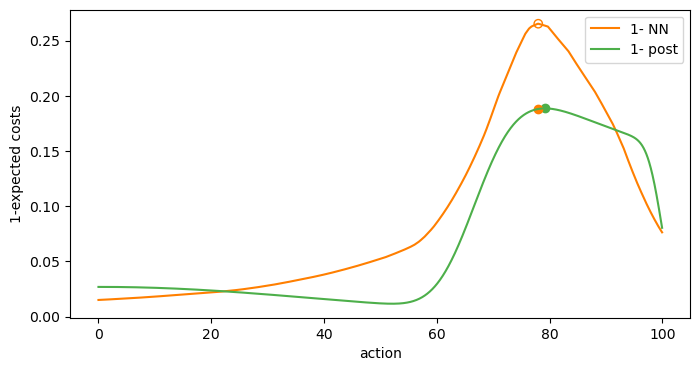

In [59]:
plt.figure(figsize=(8, 4))

expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_costs(
            x=obs,
            a=a,
            cost_fn=cost_fn
        )
        for a in a_grid
    ]
)
predicted_losses = torch.tensor([nn(obs.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])

reverse_costs = 1 - expected_posterior_losses
plt.scatter(post_action, 1-post_costs, c=color_post)
plt.scatter(nn_action, 1-nn_costs, c=color_nn)
plt.scatter(nn_action, 1-nn_estimated_costs, marker='o', facecolors='none', edgecolors=color_nn)

plt.plot(a_grid, 1 - predicted_losses, label="1- NN", c=color_nn)
plt.plot(a_grid, reverse_costs, label="1- post", c=color_post)
plt.xlabel("action")
plt.ylabel("1-expected costs")
plt.legend()
plt.show()